In [1]:
%load_ext autoreload
%autoreload 2

# Beyond RAG: From Retrieval to Agentic Systems

Author: [Vladimir Ageev](www.linkedin.com/in/vladimir-ageev-ds)  
DS / MLE with experience in recommendation systems and NLP  
Currently involved in a project on building a RAG for a search product

## Topics and goals

1. Terminology & context
2. RAG Limitations
3. Tools
4. Agentic system


I hope this session will introduce you to:
- RAG, structured outputs
- Agents & workflows in Langgraph
- MCP
- Planning & Multi-agency

### Installing dependencies

In [2]:
! pip install -r requirements.in

In [3]:
from IPython.display import display, Markdown
from pprint import pprint
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# RAG
## Ingestion

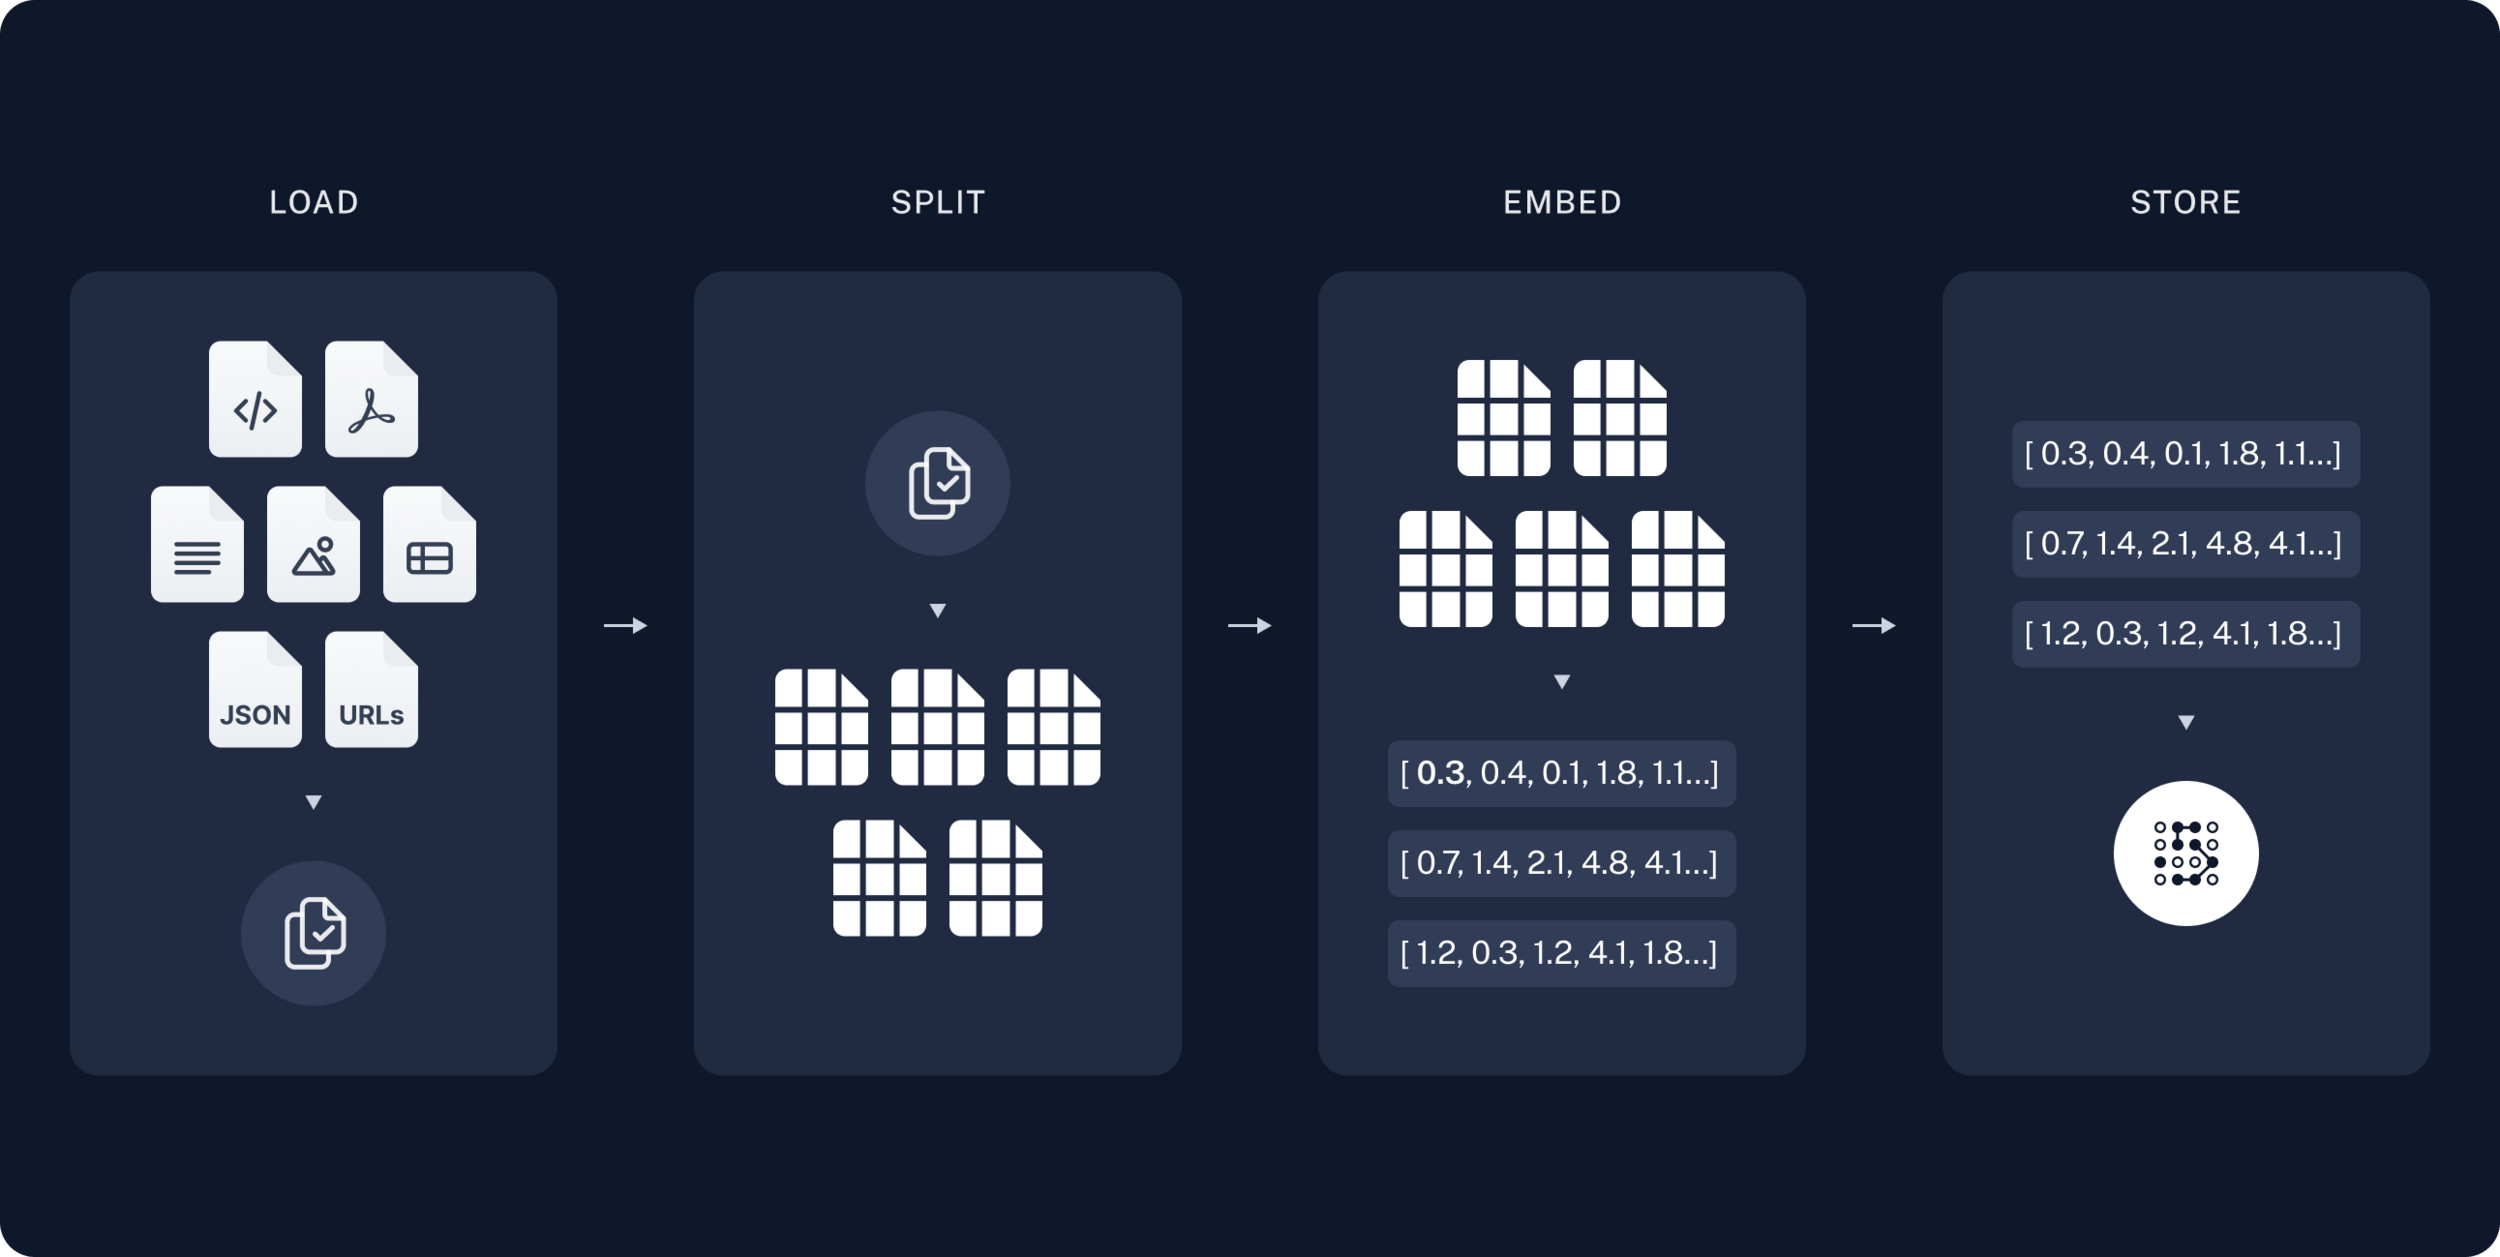

In [4]:
### Initialize vector storage
from sentence_transformers import SentenceTransformer
from langchain_chroma import Chroma
from langchain_core.embeddings.embeddings import Embeddings
from pprint import pprint


class AcrticEmbeddings(Embeddings):
    def __init__(self, model_name, batch_size=32, device="mps"):
        self.model = SentenceTransformer(
            model_name,
            trust_remote_code=True,
            device=device,
            model_kwargs={"torch_dtype": "float16"},
        )
        self.batch_size = batch_size

    def embed_documents(self, texts: list[str]) -> list[list[float]]:
        """Embed search docs.

        Args:
            texts: List of text to embed.

        Returns:
            List of embeddings.
        """
        return self.model.encode(texts, batch_size=self.batch_size)

    def embed_query(self, text: str) -> list[float]:
        """Embed query text.

        Args:
            text: Text to embed.

        Returns:
            Embedding.
        """
        return self.model.encode(text, batch_size=self.batch_size, prompt="query")


model_name = "Snowflake/snowflake-arctic-embed-m-v1.5"

chroma_client = Chroma(
    collection_name="wiki_chunks_30K",
    persist_directory="./chroma_30K",
    embedding_function=AcrticEmbeddings(model_name),
)

print(f"Number of snippets in DB: {chroma_client._collection.count()}")

/Users/vladimir/miniconda3/envs/agents-workshop/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to load context: threadlocal_context, fallback to contextvars_context
Traceback (most recent call last):
  File "/Users/vladimir/miniconda3/envs/agents-workshop/lib/python3.13/site-packages/opentelemetry/context/__init__.py", line 46, in _load_runtime_context
    return next(  # type: ignore
           ~~~~^^^^^^^^^^^^^^^^^
        iter(  # type: ignore
        ^^^^^^^^^^^^^^^^^^^^^
    ...<4 lines>...
        )
        ^
    ).load()()
    ^
StopIteration


Number of snippets in DB: 103180


In [5]:
search_result = chroma_client.search(
    query="President of the United States",
    k=5,
    search_type="similarity",
)
for result in search_result:
    print("Snippets:\n```", result.page_content[:200], "```", sep="\n")
    pprint(result.metadata)

Snippets:
```
References

local
local
Political timelines of the 2020s by year
local
```
{'chunk_index': 29,
 'id': '62651599',
 'title': '2020 local electoral calendar',
 'url': 'https://en.wikipedia.org/wiki/2020_local_electoral_calendar'}
Snippets:
```
The United States of America (USA), commonly known as the United States (U.S.) or simply America, is a country primarily located in North America and consisting of 50 states, a federal district, five 
```
{'chunk_index': 0,
 'id': '3434750',
 'title': 'United States',
 'url': 'https://en.wikipedia.org/wiki/United_States'}
Snippets:
```
External links 

Lists of 2013 term United States Supreme Court opinions
```
{'chunk_index': 0,
 'id': '45412087',
 'title': 'List of United States Supreme Court cases, volume 573',
 'url': 'https://en.wikipedia.org/wiki/List_of_United_States_Supreme_Court_cases,_volume_573'}
Snippets:
```
Indiana
Governor and Attorney General
House of Representatives and Senate
Supreme Court and Court of Appeals retent

## Generation

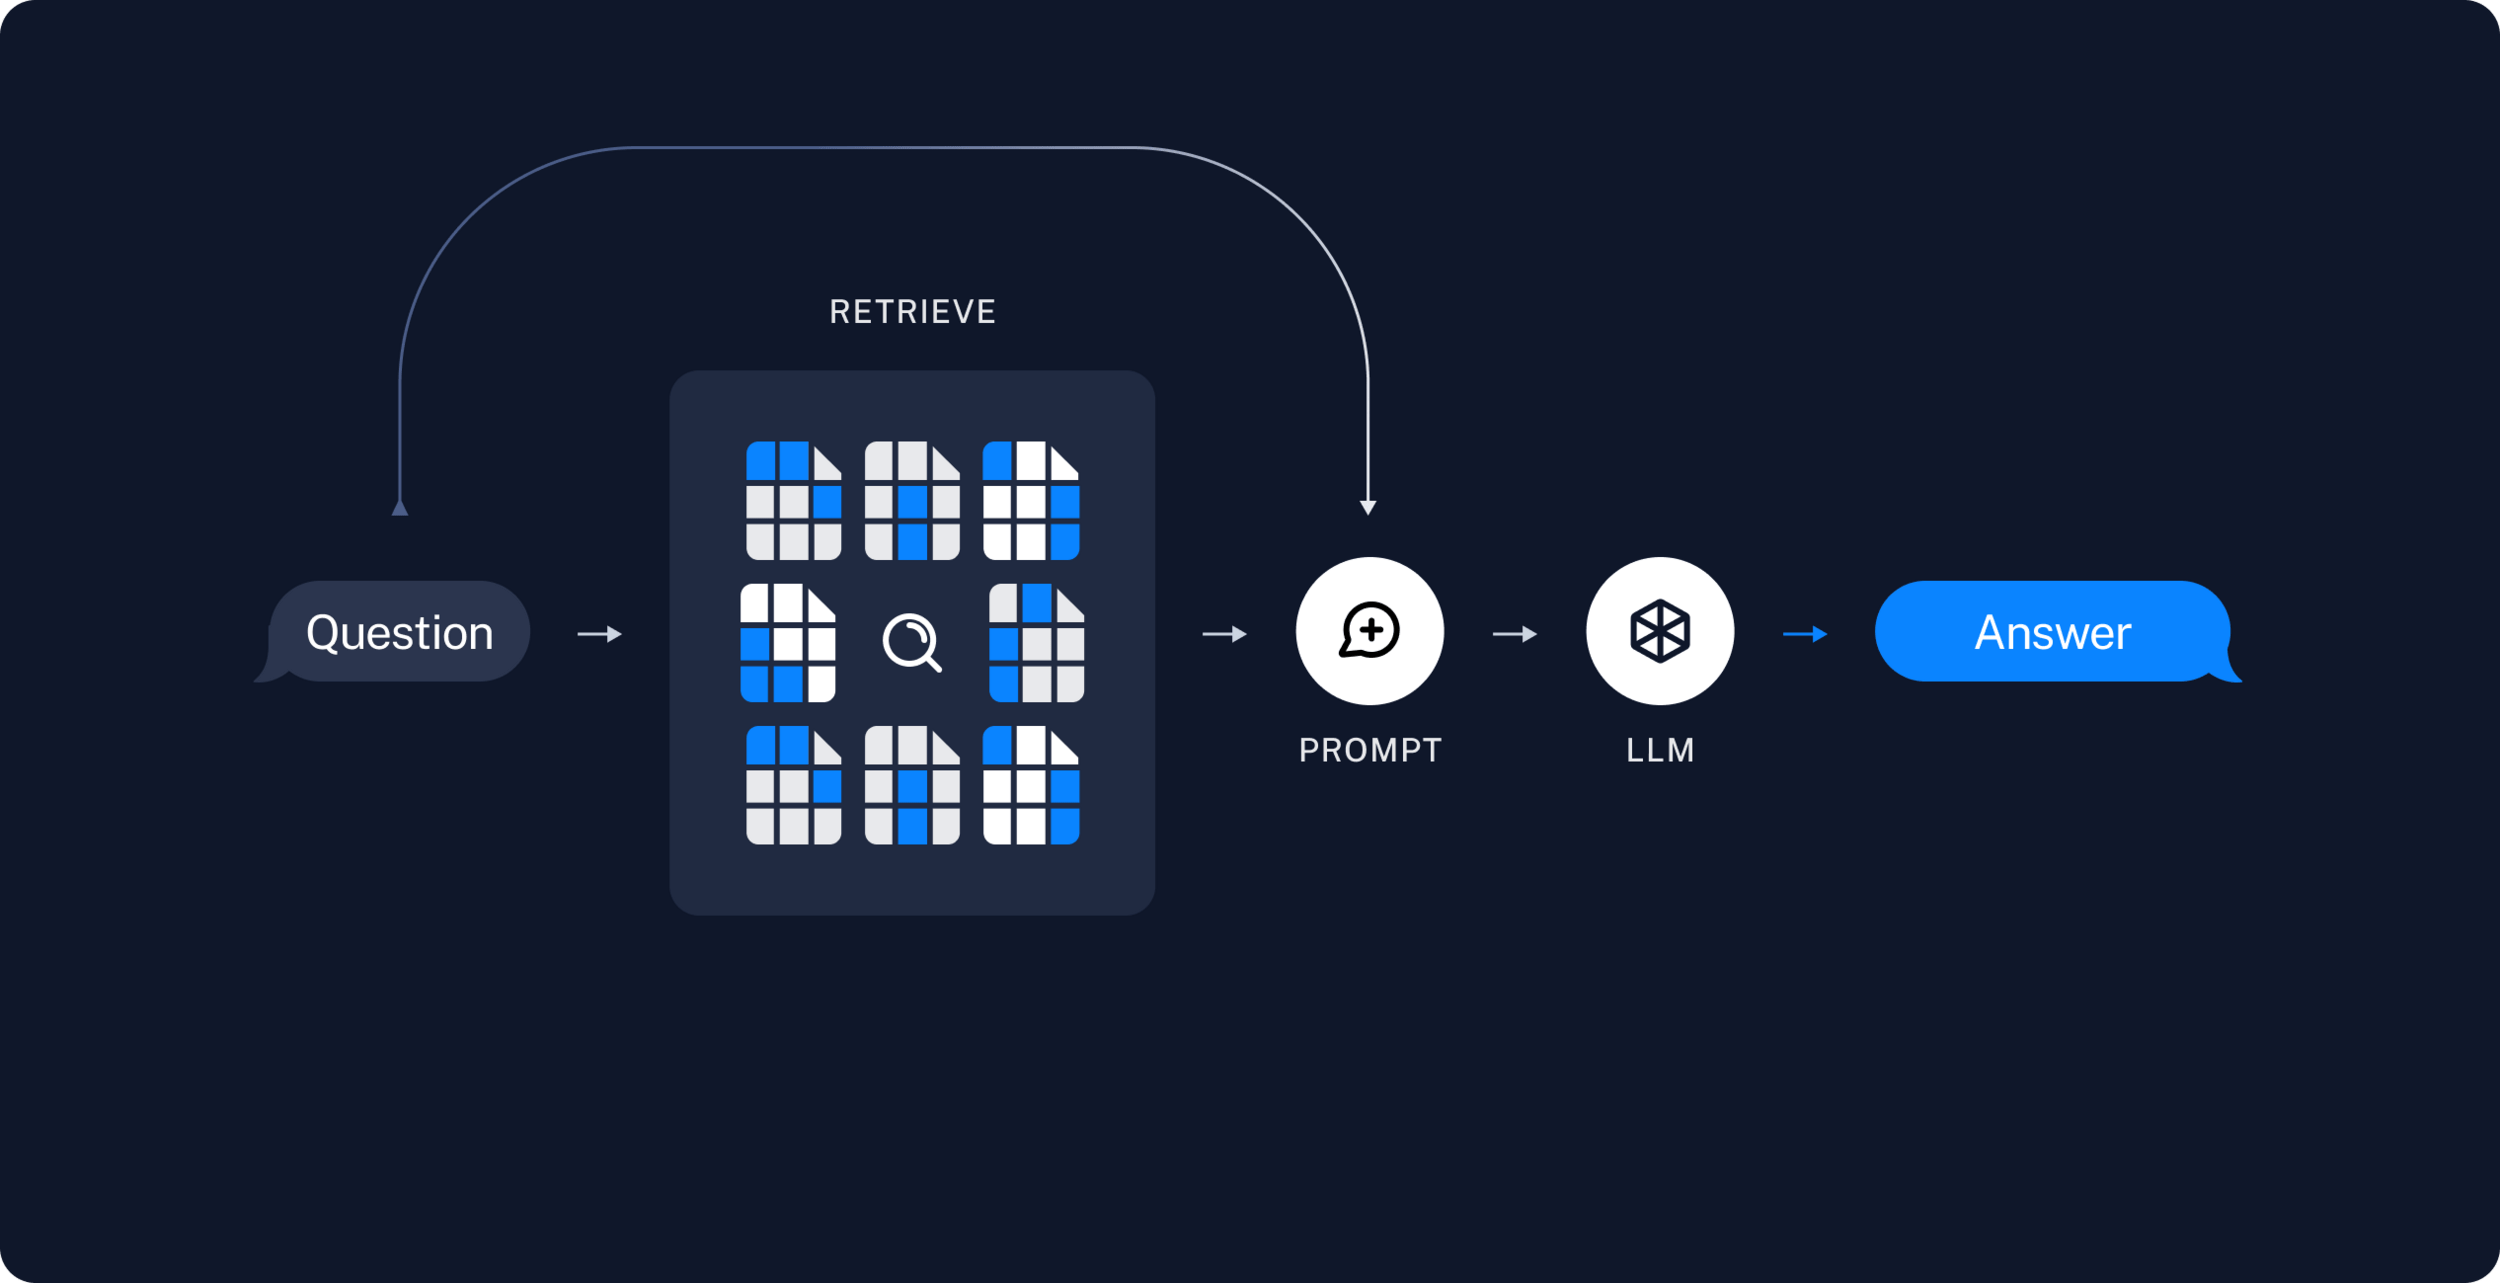

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.documents import Document
import asyncio
from prompts import AnswerWithCitations, QueryInput, AnswerStatement, CitationPrompt
from pydantic import SecretStr, BaseModel, Field
from ragas.prompt import PydanticPrompt
from IPython.display import Image, display
from rich.console import Console
from rich.markdown import Markdown
from rich import print_json

import nest_asyncio
nest_asyncio.apply()

from rich.theme import Theme

rich_console = Console()

Modern llm frameworks can use Pydantic models as input for structured output generation (Constrained Decoding)

It serves the following functions:
- Output schema is specified and validated
- It might improve overall quality through introduction of fields like `reason` to the answer, ordering of fields, verification fields, etc.

This is sometimes called Schema-Guided Reasoning

![](resources/schema-guidence.png)

In [7]:
print(AnswerStatement.model_json_schema()) 

{'properties': {'reasoning': {'description': 'Reasoning behind the answer. This should explain how the answer was derived.', 'title': 'Reasoning', 'type': 'string'}, 'answer_sentece': {'description': 'Sentence of the answer. May be a title or paragraph text in markdown format. Should be a freeform text.', 'title': 'Answer Sentece', 'type': 'string'}, 'reference_url': {'anyOf': [{'type': 'string'}, {'type': 'null'}], 'description': 'URL of the reference from given context', 'title': 'Reference Url'}, 'reference_title': {'anyOf': [{'type': 'string'}, {'type': 'null'}], 'description': 'Title of the reference from given context', 'title': 'Reference Title'}}, 'required': ['reasoning', 'answer_sentece', 'reference_url', 'reference_title'], 'title': 'AnswerStatement', 'type': 'object'}


The whole prompt may be composed in a similar manner (as it is used in Ragas)

In [8]:
print(CitationPrompt().to_string())

Generate answer to the question based on the given context.
    Answer may consist of multiple sentences, some of them may be with references.
    Come up with a full answer step-by-step, using multiple elements of the context.
    Answer should be in markdown format following the template:
    ```
    # Title
    Here is the what context provides to your question:
    * statement 1
    * statement 2 [reference title](reference url)
    ```
    
Please return the output in a JSON format that complies with the following schema as specified in JSON Schema:
{"$defs": {"AnswerStatement": {"properties": {"reasoning": {"description": "Reasoning behind the answer. This should explain how the answer was derived.", "title": "Reasoning", "type": "string"}, "answer_sentece": {"description": "Sentence of the answer. May be a title or paragraph text in markdown format. Should be a freeform text.", "title": "Answer Sentece", "type": "string"}, "reference_url": {"anyOf": [{"type": "string"}, {"type":

In [9]:
class LLMConfig(BaseModel):
    api_key: SecretStr
    model_name: str
    temperature: int = Field(default=0)
    max_tokens: int = Field(default=4096)


class RAG:
    def __init__(self, config: LLMConfig, retriever):
        self.llm_model = ChatOpenAI(**config.model_dump()).with_structured_output(
            AnswerWithCitations
        )
        self.retriever = retriever

    def call_llm(
        self, query: str, prompt: PydanticPrompt
    ) -> tuple[str, list[Document]]:
        return asyncio.run(self.call_llm_async(query=query, prompt=prompt))

    async def call_llm_async(
        self, query: str, prompt: PydanticPrompt
    ) -> tuple[str, list[Document]]:
        context = await self.retriever.ainvoke(query)
        complete_prompt = prompt.to_string(QueryInput(question=query, context=context))
        try:
            response = await self.llm_model.ainvoke(complete_prompt)
        except Exception as e:
            print(f"Error in answer generation: {e}")
            response = AnswerWithCitations(
                statements=[
                    AnswerStatement(
                        answer_sentece="Error in generating answer.",
                        reference_url=None,
                        reference_title=None,
                    )
                ]
            )
        return response, context

In [10]:
from pydantic import SecretStr
import os
import dotenv

dotenv.load_dotenv()
# from google.colab import userdata
api_key = SecretStr(os.getenv("OPENAI_API_KEY"))

llm_config = LLMConfig(
    api_key=api_key,
    model_name="gpt-5-mini",
    temperature=0,
    max_tokens=4096
)

retriever = chroma_client.as_retriever(
    search_type="mmr", search_kwargs={"k": 20, "fetch_k": 50, "lambda_mult": 0.8}
)

llm_client = RAG(config=llm_config, retriever=retriever)

In [11]:
response, context = llm_client.call_llm(
    query="Who won the most gold medals in the Tokyo Olympics?",
    prompt=CitationPrompt(),
)

In [12]:
for doc in context:
    print(f"Title: {doc.metadata['title']}")
    print(f"URL: {doc.metadata['url']}")
    print(f"Content: {doc.page_content[:100]}")
    print()

Title: 2020 Summer Olympics
URL: https://en.wikipedia.org/wiki/2020_Summer_Olympics
Content: The Games were the fourth Olympic Games to be held in Japan, following the 1964 Summer Olympics (Tok

Title: 2020 Summer Olympics
URL: https://en.wikipedia.org/wiki/2020_Summer_Olympics
Content: The United States topped the medal table by both total golds (39) and total medals (113), with China

Title: 2017 European Diving Championships – Women's 10 metre platform
URL: https://en.wikipedia.org/wiki/2017_European_Diving_Championships_–_Women's_10_metre_platform
Content: Results

Green denotes finalists

References
 Official results

Women's 10 metre platform
Euro

Title: 2008 IAAF World Indoor Championships – Men's 60 metres
URL: https://en.wikipedia.org/wiki/2008_IAAF_World_Indoor_Championships_–_Men's_60_metres
Content: Medalists

Heats

Semifinals

Final

60 metres at the World Athletics Indoor Championships
60 metres

Title: 1987 in sports
URL: https://en.wikipedia.org/wiki/1987_in_sports
Co

In [13]:
pprint(response.statements)

[AnswerStatement(reasoning='Provide the country that won the most gold medals as the answer title.', answer_sentece='## United States', reference_url=None, reference_title=None),
 AnswerStatement(reasoning='Introduce the supporting context from the provided documents.', answer_sentece='Here is the what context provides to your question:', reference_url=None, reference_title=None),
 AnswerStatement(reasoning='The 2020 Summer Olympics article explicitly states which nation topped the gold medal count and gives the totals.', answer_sentece='* The United States topped the medal table by both total golds (39) and total medals (113).', reference_url='https://en.wikipedia.org/wiki/2020_Summer_Olympics', reference_title='2020 Summer Olympics'),
 AnswerStatement(reasoning='The same source provides the runner-up nation and its medal totals for context.', answer_sentece='* China finished second with 38 golds and 89 total medals.', reference_url='https://en.wikipedia.org/wiki/2020_Summer_Olympics'

In [14]:
rich_console.print(Markdown(response.format_response()))

United States                                                   

Here is the what context provides to your question:                                                                

 • The United States topped the medal table by both total golds (39) and total medals (113). []8;id=486532;https://en.wikipedia.org/wiki/2020_Summer_Olympics\2020 Summer Olympics]8;;\]
 • China finished second with 38 golds and 89 total medals. []8;id=467355;https://en.wikipedia.org/wiki/2020_Summer_Olympics\2020 Summer Olympics]8;;\]                                 
 • Host nation Japan finished third, setting a record for the most gold medals and total medals ever won by their  
   delegation at an Olympic Games with 27 and 58. []8;id=141690;https://en.wikipedia.org/wiki/2020_Summer_Olympics\2020 Summer Olympics]8;;\]                                           

### Our RAG Limitations

1. Up-to-date facts

In [15]:
response, context = llm_client.call_llm(
    query="Who is the King of England?",
    prompt=CitationPrompt(),
)
rich_console.print(Markdown(response.format_response()))

Charles III                                                    

Here is the what context provides to your question:                                                                

 • Elizabeth II was Queen of the United Kingdom and other Commonwealth realms from 6 February 1952 until her death 
   on 8 September 2022. []8;id=133873;https://en.wikipedia.org/wiki/Elizabeth_II\Elizabeth II]8;;\]                                                                             
 • Elizabeth II and Philip Mountbatten had four children: Charles, Anne, Andrew, and Edward. []8;id=106545;https://en.wikipedia.org/wiki/Elizabeth_II\Elizabeth II]8;;\]        
 • Therefore, following Elizabeth II's death, her eldest son Charles succeeded to the throne and is the King       
   (styled Charles III). []8;id=641835;https://en.wikipedia.org/wiki/Elizabeth_II\Elizabeth II]8;;\]                                                                            

2. Single-turn search

In [16]:
response, context = llm_client.call_llm(
    query="Average age of the latest 5 presidents of the United States",
    prompt=CitationPrompt(),
)
display(Markdown(response.format_response()))

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                           Average age of the latest 5 presidents of the United States                           ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

Here is the what context provides to your question:                                                                

 • The incumbent president is Joe Biden. []8;id=108273;https://en.wikipedia.org/wiki/List_of_presidents_of_the_United_States\List of presidents of the United States]8;;\]                                 
 • The provided context does not include the birthdates or ages of the latest five presidents, so an average age   
   cannot be calculated from these documents alone.                                                                
 • To compute the average age you need the birthdates (or current ages) of the five most recent presidents (the    
   incumbent plus the four immediate predecessors); provide those birthdates or links to their pages and I will    
   calculate the average.

3. Stateless

Cannot continue conversation 

# So, what are agents?

1. Agents are to overcome the “limitations” of LLMs. 
    - instead of training for solving the tasks, let them use tools to solve a task!

2. Anthropic / Langgraph: "Workflow" vs "Agents":
    - "**Workflows** are systems where LLMs and tools are orchestrated through predefined code paths."
    - "**Agents** are systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks."
    - “**Agents** can be used for open-ended problems where it’s difficult or impossible to predict the required number of steps, and where you can’t hardcode a fixed path.“
    - **Agents** have **environment** and **feedback** from that environment (e.g. SWE Bench)

![](resources/agent_workflow.png)

3. OpenAI: "An AI system that has instructions (what it should do), guardrails (what it should not do), and access to tools (what it can do) to take action on the user’s behalf"

# Agentic system

![](resources/flow-schema-1.png)

In [17]:
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langchain_core.messages import (
    BaseMessage,
    SystemMessage,
    HumanMessage,
    ToolMessage,
    AIMessage,
    get_buffer_string,
)
from typing import Literal, Sequence, Annotated, TypedDict
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver
import operator
import json

## Tools

In [18]:
from tools import tavily_search, think_tool, ConductResearch, ResearchComplete

### Retrieval as mcp tool

![](resources/flow-schema-2.png)

In [19]:
from langchain_mcp_adapters.client import MultiServerMCPClient

mcp_config = {
    "retrieval": {
        "command": "python",
        "args": ["-m", "mcp_retrieval"],
        "transport": "stdio",
    }
}

_client = None


def get_mcp_client():
    """Get or initialize MCP client lazily to avoid issues with LangGraph Platform."""
    global _client
    if _client is None:
        _client = MultiServerMCPClient(mcp_config)
    return _client


retrieval_client = get_mcp_client()
retrieval_tools = await retrieval_client.get_tools()
for tool in retrieval_tools:
    rich_console.print(tool.description, tool.name, tool.args, sep="\n\n")

Retrieve relevant passages from a local, offline vector index — not the web.

This tool searches only your locally indexed documents (Chroma) and never
accesses the internet. Results are semantic matches from your curated corpus,
not live web pages or news. Use web search tools for external or up-to-date
information.

Args:
    query (str): Natural-language query to search the local index.
    top_k (int, optional): Maximum number of passages to return. Defaults to 3.

Returns:
    list[dict]: Each item includes 'content' (text) and may include
    'url' and 'title' when available.


retrieve_docs
{'query': {'title': 'Query', 'type': 'string'}, 'top_k': {'default': 3, 'title': 'Top K', 'type': 'integer'}}

In [20]:
search_results = await retrieval_tools[0].ainvoke(
    {"query": "Who is the King of England?", "k": 3}
)

for result in search_results:
    rich_console.print(result)

{
  "content": "of England, and ended his life as a prisoner under Queen Elizabeth.",
  "url": "https://en.wikipedia.org/wiki/Savage_family",
  "title": "Savage family"
}

{
  "content": "really is or whether all of this is an act of his craft.",
  "url": "https://en.wikipedia.org/wiki/Adventures_of_Omanakuttan",
  "title": "Adventures of Omanakuttan"
}

{
  "content": "party and effectively allowing Maine to rule France for the next eight years.",
  "url": "https://en.wikipedia.org/wiki/Louis_XV",
  "title": "Louis XV"
}

### Web search

In [21]:
print("Description:", tavily_search.description)
print("Name:", tavily_search.name)
print("Args:", json.dumps(tavily_search.args, indent=2))

Description: Fetch results from Tavily search API with content summarization.
Name: tavily_search
Args: {
  "query": {
    "description": "A single search query to execute. Max 200 characters.",
    "title": "Query",
    "type": "string"
  },
  "max_results": {
    "default": 3,
    "description": "Maximum number of results to return",
    "title": "Max Results",
    "type": "integer"
  },
  "topic": {
    "default": "general",
    "description": "Topic to filter results by ('general', 'news', 'finance')",
    "enum": [
      "general",
      "news",
      "finance"
    ],
    "title": "Topic",
    "type": "string"
  }
}


In [22]:
query = "Who is the King of England?"
params = {"query": query, "max_results": 3, "topic": "general"}
result = tavily_search.invoke(params)

i = 0
for url, doc in result.items():
    i += 1
    title = doc.get("title", "(no title)")
    snippet = (doc.get("content", "") or "").replace("\n", " ")[:200]
    print(f"{i}. {title}\n   {url}\n   {snippet}...\n")

1. Monarchy of the United Kingdom - Wikipedia
   https://en.wikipedia.org/wiki/Monarchy_of_the_United_Kingdom
   The monarch since 8 September 2022 is King Charles III, who ascended the throne on the death of Queen Elizabeth II, his mother....

2. Charles III - Wikipedia
   https://en.wikipedia.org/wiki/Charles_III
   Charles III (Charles Philip Arthur George; born 14 November 1948) is King of the United Kingdom and the 14 other Commonwealth realms....

3. King Charles III | Biography, Prince, Wife, Cancer, & Age | Britannica
   https://www.britannica.com/biography/Charles-III-king-of-the-United-Kingdom
   * When did Charles III become king of the United Kingdom? * What was Charles III's title before he became king? **Charles III** (born November 14, 1948, Buckingham Palace, London, England) is the king...



### Think tool

![](resources/sonnet-scores.png)

In [23]:
print("Description:", think_tool.description, "\n\n")
print("Name:", think_tool.name, "\n\n")
print("Args:", json.dumps(think_tool.args, indent=2), "\n\n")

Description: Tool for strategic reflection on research progress and decision-making. Use this tool after each search to analyze results and plan next steps systematically.
This creates a deliberate pause in the research workflow for quality decision-making. When to use:
- After receiving search results: What key information did I find?
- Before deciding next steps: Do I have enough to answer comprehensively?
- When assessing research gaps: What specific information am I still missing?
- Before concluding research: Can I provide a complete answer now? Reflection should address:
1. Analysis of current findings - What concrete information have I gathered?
2. Gap assessment - What crucial information is still missing?
3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
4. Strategic decision - Should I continue searching or provide my answer? 


Name: think_tool 


Args: {
  "reflection": {
    "description": "Your detailed reflection on research progress, find

In [24]:
think_tool.invoke({"reflection": "I need to search for the current King of England."})

'Reflection recorded: I need to search for the current King of England.'

In [25]:
mcp_tools = await retrieval_client.get_tools()
mcp_tools_by_name = {tool.name: tool for tool in mcp_tools}
local_tools = [think_tool, tavily_search]
local_tools_by_name = {"think_tool": think_tool, "web_search": tavily_search}

## Research Subagent

![](resources/flow-schema-3.png)

In [26]:
class SubagentState(TypedDict):
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]
    research_topic: str
    report: AnswerWithCitations
    tool_call_iterations: Annotated[int, operator.add]


class SubagentOutput(TypedDict):
    report: AnswerWithCitations
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]

![](resources/flow-schema-4.png)

In [27]:
from prompts import subagentPrompt, SummaryPrompt, SummaryInput

async def llm_call(
    state: SubagentState,
) -> Command[Literal["generate_summary", "tools_node"]]:
    model = ChatOpenAI(model_name="gpt-5-mini", temperature=0, max_tokens=4096)
    model_with_tools = model.bind_tools(local_tools + mcp_tools)
    response = model_with_tools.invoke(
        [
            SystemMessage(
                content=subagentPrompt.format(
                    research_topic=state["research_topic"],
                )
            )
        ]
        + state["researcher_messages"]
    )

    if not response.tool_calls or state["tool_call_iterations"] >= 5:
        print("Final response generated, moving to summary.")
        return Command(
            goto="generate_summary", update={"researcher_messages": [response]}
        )
    else:
        print(f"Tool calls detected ({len(response.tool_calls)}), invoking tools node.")
        return Command(
            goto="tools_node",
            update={
                "researcher_messages": [response],
                "tool_call_iterations": state["tool_call_iterations"] + 1,
            },
        )

In [28]:
llm_call_response = await llm_call(
    {
        "research_topic": "Genoa Cricket and Football Club",
        "tool_call_iterations": 0,
        "researcher_messages": [],
    }
)

print(llm_call_response.update)

Tool calls detected (1), invoking tools node.
{'researcher_messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_H1Jxph7wfNRhVgQ02UizxuP0', 'function': {'arguments': '{"query":"Genoa Cricket and Football Club history founding honours stadium Derby della Lanterna colors nickname", "top_k":5}', 'name': 'retrieve_docs'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 301, 'prompt_tokens': 980, 'total_tokens': 1281, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 256, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CA6NzOoOvIcizqSdzD5reEas4bYoS', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9fcc0e4a-1d93-4110-9896-1f281edb2396-0', tool_calls=[{'name': 'retrieve_docs', 'args': {'query': 'G

![](resources/flow-schema-5.png)

In [29]:
async def tools_node(state: SubagentState):
    tool_calls = state["researcher_messages"][-1].tool_calls
    mcp_tools_by_name = {tool.name: tool for tool in mcp_tools}
    local_tools_by_name = {tool.name: tool for tool in local_tools}

    async def execute_tools():
        observations = []
        for tool_call in tool_calls:
            if tool_call["name"] in local_tools_by_name:
                print(f"Invoking local tool: {tool_call['name']}")
                tool = local_tools_by_name[tool_call["name"]]
                observation = tool.invoke(tool_call["args"])

            elif tool_call["name"] in mcp_tools_by_name:
                print(
                    f"Invoking MCP tool: {tool_call['name']} with args: {tool_call['args']}"
                )
                tool = mcp_tools_by_name[tool_call["name"]]
                observation = await tool.ainvoke(tool_call["args"])
                observation = json.dumps(observation)

            observations.append(observation)

        tool_outputs = [
            ToolMessage(
                content=observation,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
            for observation, tool_call in zip(observations, tool_calls)
        ]

        return tool_outputs

    messages = await execute_tools()

    return {"researcher_messages": messages}

In [30]:
tool_node_response = await tools_node(
    {
        "research_topic": "Genoa Cricket and Football Club",
        "tool_call_iterations": 1,
        "researcher_messages": llm_call_response.update["researcher_messages"],
    }
)

Invoking MCP tool: retrieve_docs with args: {'query': 'Genoa Cricket and Football Club history founding honours stadium Derby della Lanterna colors nickname', 'top_k': 5}


In [31]:
for msg in tool_node_response["researcher_messages"]:
    pprint(msg.content)

('["{\\n  \\"content\\": \\"History\\\\n\\\\nThe club was founded on 7 '
 'September 1893 as Genoa Cricket & Athletic Club. In its earliest years, it '
 'principally competed in athletics and cricket. Association football was only '
 'a secondary concern. Since the club was set up to represent England abroad, '
 'the original shirts worn by the organisation were white, the same colour as '
 'the England national team shirt. At first Italians were not permitted to '
 "join as it was a British sporting club abroad. Genoa's activities took place "
 "in the north-west of the city in the Campasso area, at the Piazza d'Armi. "
 'The men who initially handled the management of the club were;\\\\n\\\\nOn '
 '10 April 1897 the footballing section of the club, already in existence '
 'since 1893, became predominant thanks to James Richardson Spensley. It was '
 'among the oldest in Italian football at the time, only four other clubs (all '
 'in Turin.) had been founded. Italians were allowed to 

In [32]:
def generate_summary(state: SubagentState):
    model = ChatOpenAI(
        model_name="gpt-5-mini", temperature=0, max_tokens=4096
    ).with_structured_output(AnswerWithCitations)
    print("Generating summary report...")
    messages_list = [
        m.content
        for m in state["researcher_messages"]
        if isinstance(m, (HumanMessage, AIMessage, ToolMessage))
    ]
    prompt = SummaryPrompt().to_string(SummaryInput(messages=messages_list))

    result = model.invoke(prompt)

    return {"report": result, "researcher_messages": state["researcher_messages"]}

In [33]:
summary_report = generate_summary(
    {
        "researcher_messages": llm_call_response.update["researcher_messages"]
        + tool_node_response["researcher_messages"],
        "tool_call_iterations": 1,
        "research_topic": "Genoa Cricket and Football Club",
    }
)

Generating summary report...


In [34]:
rich_console.print(Markdown(summary_report["report"].format_response()))

Genoa CFC — summary of founding and early football history The club was founded on 7 September 1893 as Genoa       
Cricket & Athletic Club, originally focused on athletics and cricket before football became dominant. []8;id=274305;https://en.wikipedia.org/wiki/Genoa_CFC\Genoa CFC]8;;\]  
As a British-established club abroad, Genoa initially wore white shirts like the England national team and         
originally excluded Italians from membership. []8;id=274305;https://en.wikipedia.org/wiki/Genoa_CFC\Genoa CFC]8;;\] On 10 April 1897 the football section became predominant 
under James Richardson Spensley; early matches included a 1–0 home loss to a mixed Internazionale Torino/F.B.C.    
Torinese side and the club's first victory, 2–0 away at UPS Alessandria. []8;id=274305;https://en.wikipedia.org/wiki/Genoa_CFC\Genoa CFC]8;;\] Genoa is among the oldest     
football clubs in Italy and is referenced in lists of the world’s oldest football clubs and related histories.     
[]8;id=756127;https://en.wikipedia.org/wiki/Oldest_football_clubs\Oldest football clubs]8;;\] Other documents in the message batch (e.g., pages on Dick Bayliss, FC Augsburg seasons, and
Malaysian stadiums) are present but are miscellaneous and not directly relevant to Genoa's history.

In [35]:
def build_subagent_graph():
    graph_builder = StateGraph(state_schema=SubagentState)
    graph_builder.add_node("llm_call", llm_call)
    graph_builder.add_node("tools_node", tools_node)
    graph_builder.add_node("generate_summary", generate_summary)

    graph_builder.add_edge(START, "llm_call")

    graph_builder.add_edge("tools_node", "llm_call")
    graph_builder.add_edge("generate_summary", END)
    return graph_builder.compile()

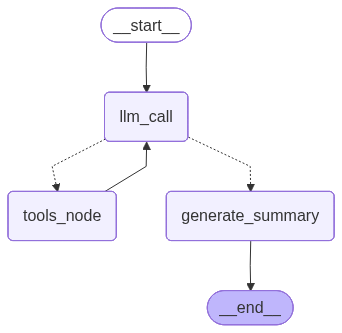

In [36]:
subagent_graph = build_subagent_graph()
display(Image(subagent_graph.get_graph(xray=True).draw_mermaid_png()))

In [37]:
from langfuse.langchain import CallbackHandler
from langfuse import get_client
from langfuse import Langfuse

# print(dotenv.load_dotenv())
# langfuse = Langfuse(
#   secret_key=os.getenv("LANGFUSE_SECRET_KEY"),
#   public_key=os.getenv("LANGFUSE_PUBLIC_KEY"),
#   host=os.getenv("LANGFUSE_HOST")
# )

# langfuse = get_client(public_key=os.getenv("LANGFUSE_PUBLIC_KEY"))
# langfuse_handler = CallbackHandler(public_key=os.getenv("LANGFUSE_PUBLIC_KEY"))
# langfuse.auth_check()

result = await subagent_graph.ainvoke(
    {
        "research_topic": "Who is the current reigning monarch commonly referred to as the 'King of England' (provide name and regnal title)?",
        "researcher_messages": [],
        "tool_call_iterations": 0,
    },
    # config={"callbacks": [langfuse_handler]}
)

Tool calls detected (1), invoking tools node.
Invoking MCP tool: retrieve_docs with args: {'query': 'current reigning monarch King of England Charles III name regnal title', 'top_k': 3}
Tool calls detected (1), invoking tools node.
Invoking local tool: think_tool
Final response generated, moving to summary.
Generating summary report...


In [38]:
rich_console.print(Markdown(result["report"].format_response()))

King Charles III The current monarch commonly called "King of England" is Charles Philip Arthur George, who reigns 
as His Majesty King Charles III. []8;id=570260;https://en.wikipedia.org/wiki/Charles_III\Charles III]8;;\] Source: Wikipedia entry for Charles III lists his full name (Charles
Philip Arthur George) and regnal title (King Charles III). []8;id=570260;https://en.wikipedia.org/wiki/Charles_III\Charles III]8;;\] Conclusion: Name and regnal title         
provided; no further information required for this question.

# Research Supervisor

![](resources/flow-schema-6.png)

In [39]:
class RagGraphState(MessagesState):
    search_topics: Annotated[list[str], operator.add]
    plan: Annotated[list[str], operator.add]
    supervisor_messages_buffer: Annotated[Sequence[BaseMessage], add_messages]
    clarification_rounds: Annotated[int, operator.add]
    subagents_calls: Annotated[int, operator.add]
    max_subagent_calls: Annotated[int, operator.add]
    current_task: str
    final_answer: AnswerWithCitations


class FlowInput(MessagesState):
    pass

## Delegation

![](resources/flow-schema-7.png)

In [40]:
from prompts import supervisorPrompt

async def supervisor(
    state: RagGraphState,
) -> Command[Literal["delegate", "execute_plan"]]:
    print("Supervisor called")
    # limit of the calls achieved
    call_limit = state["subagents_calls"] >= state.get("max_subagent_calls", 5)
    # research was complete
    research_complete = False
    if len(state["supervisor_messages_buffer"]) > 0 and hasattr(
        state["supervisor_messages_buffer"][-1], "tool_calls"
    ):
        research_complete = any(
            tc["name"] == "ResearchComplete"
            for tc in state["supervisor_messages_buffer"][-1].tool_calls
        )

    if call_limit or research_complete:
        print("Call limit reached or research complete, finalizing answer.")
        return Command(goto="execute_plan")

    model = ChatOpenAI(model_name="gpt-5-mini", temperature=0, max_tokens=4096)
    model = model.bind_tools([think_tool, ResearchComplete, ConductResearch])
    prompt = supervisorPrompt.format(
        research_topic=state["current_task"],
        max_researcher_iterations=state.get("max_subagent_calls", 5),
        max_concurrent_research_units=2,
    )

    response = await model.ainvoke(
        [
            SystemMessage(content=prompt),
        ]
        + state["supervisor_messages_buffer"]
    )

    if not response.tool_calls:
        print("No tool calls detected, finalizing answer.")
        return Command(
            goto="finalize_answer", update={"supervisor_messages_buffer": [response]}
        )

    print(f"Tool calls detected ({len(response.tool_calls)}), delegating to subagent.")
    return Command(
        goto="delegate",
        update={
            "supervisor_messages_buffer": [response],
        },
    )

In [41]:
supervision_response = await supervisor(
    {
        "subagents_calls": 0,
        "max_subagent_calls": 5,
        "current_task": "Who is King of England? Give a brief overview.",
        "supervisor_messages_buffer": [],
    }
)

Supervisor called
Tool calls detected (1), delegating to subagent.


In [42]:
supervision_response.goto

'delegate'

In [43]:
for m in supervision_response.update["supervisor_messages_buffer"]:
    print(m)

content='' additional_kwargs={'tool_calls': [{'id': 'call_462naI0W51uOdcjwVYVXRsNv', 'function': {'arguments': '{"reflection":"Plan: The user asks \\"Who is King of England? Give a brief overview.\\" This is simple fact-finding. Sub-tasks: 1) Confirm current monarch and correct title (King of the United Kingdom vs King of England). 2) Provide brief bio: name, birth, accession date, predecessor. 3) Describe constitutional role and duties. 4) List heir apparent and immediate family. 5) Note main residences and notable recent events. 6) Provide 2-3 authoritative sources and state information is current as of 2025-08-30. Research delegation: Use a single ConductResearch agent to fetch concise, up-to-date summary and cite sources (royal.uk, BBC, reputable news). Keep it short (4-6 bullets/paragraphs). After the agent returns results, assess whether further detail is needed. If returned data is complete and consistent, finish. Otherwise, request follow-up. Proceed to call ConductResearch."}'

![](resources/flow-schema-8.png)

In [44]:
import prompts


async def delegate(state: RagGraphState) -> Command[Literal["supervisor", "__end__"]]:
    print("Delegate called")
    last_message = state["supervisor_messages_buffer"][-1]
    tool_messages = []
    try:
        # Separate think_tool calls from ConductResearch calls
        think_tool_calls = [
            tool_call
            for tool_call in last_message.tool_calls
            if tool_call["name"] == "think_tool"
        ]

        conduct_research_calls = [
            tool_call
            for tool_call in last_message.tool_calls
            if tool_call["name"] == "ConductResearch"
        ]

        # Handle think_tool calls (synchronous)
        for tool_call in think_tool_calls:
            observation = think_tool.invoke(tool_call["args"])
            tool_messages.append(
                ToolMessage(
                    content=observation,
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        # Handle ConductResearch calls (asynchronous)
        if conduct_research_calls:
            # Launch parallel research agents
            coros = [
                subagent_graph.ainvoke(
                    {
                        "researcher_messages": [
                            HumanMessage(content=tool_call["args"]["research_topic"])
                        ],
                        "research_topic": tool_call["args"]["research_topic"],
                    }
                )
                for tool_call in conduct_research_calls
            ]

            # Wait for all research to complete
            tool_results = await asyncio.gather(*coros)
            research_tool_messages = []
            for result, tool_call in zip(tool_results, conduct_research_calls):
                result_content = result.get(
                    "report", "Error synthesizing research report"
                )
                if isinstance(result_content, prompts.AnswerWithCitations):
                    result_content = result_content.model_dump_json()
                research_tool_messages.append(
                    ToolMessage(
                        content=result_content,
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"],
                    )
                )
            tool_messages.extend(research_tool_messages)
    except Exception as e:
        print(f"Error in delegate execution: {e}")
        tool_messages.append(
            ToolMessage(
                content=f"Error in delegate execution: {e}",
                name="Error",
                tool_call_id="error",
            )
        )
        return Command(goto="__end__")

    return Command(
        goto="supervisor",
        update={
            "supervisor_messages_buffer": tool_messages,
            "subagents_calls": state["subagents_calls"] + len(conduct_research_calls),
        },
    )

In [45]:
await delegate(
    {
        "subagents_calls": 0,
        "max_subagent_calls": 5,
        "current_task": "Who is King of England? Give a brief overview.",
        "supervisor_messages_buffer": supervision_response.update[
            "supervisor_messages_buffer"
        ],
    }
)

Delegate called


Command(update={'supervisor_messages_buffer': [ToolMessage(content='Reflection recorded: Plan: The user asks "Who is King of England? Give a brief overview." This is simple fact-finding. Sub-tasks: 1) Confirm current monarch and correct title (King of the United Kingdom vs King of England). 2) Provide brief bio: name, birth, accession date, predecessor. 3) Describe constitutional role and duties. 4) List heir apparent and immediate family. 5) Note main residences and notable recent events. 6) Provide 2-3 authoritative sources and state information is current as of 2025-08-30. Research delegation: Use a single ConductResearch agent to fetch concise, up-to-date summary and cite sources (royal.uk, BBC, reputable news). Keep it short (4-6 bullets/paragraphs). After the agent returns results, assess whether further detail is needed. If returned data is complete and consistent, finish. Otherwise, request follow-up. Proceed to call ConductResearch.', name='think_tool', tool_call_id='call_462n

In [46]:
def execute_plan(
    state: RagGraphState,
) -> Command[Literal["supervisor", "finalize_answer"]]:
    print("Execute plan called with state plan:", state["plan"])
    if state["plan"]:
        current_task = state["plan"].pop(0)
        return Command(
            goto="supervisor",
            update={
                "current_task": current_task,
                "subagents_calls": 0,
                "plan": state["plan"],
                "max_subagent_calls": 5,
                "supervisor_messages_buffer": state.get(
                    "supervisor_messages_buffer", []
                ),
            },
        )
    return Command(goto="finalize_answer")

In [47]:
plan = ["task1", "task2"]
for i in range(3):
    response = execute_plan(
        {
            "plan": plan,
        }
    )
    plan = response.update["plan"] if response.update else []
    print(response)

Execute plan called with state plan: ['task1', 'task2']
Command(update={'current_task': 'task1', 'subagents_calls': 0, 'plan': ['task2'], 'max_subagent_calls': 5, 'supervisor_messages_buffer': []}, goto='supervisor')
Execute plan called with state plan: ['task2']
Command(update={'current_task': 'task2', 'subagents_calls': 0, 'plan': [], 'max_subagent_calls': 5, 'supervisor_messages_buffer': []}, goto='supervisor')
Execute plan called with state plan: []
Command(goto='finalize_answer')


In [48]:
from prompts import FinalReportPrompt, AnswersCollection


def finalize_answer(state: RagGraphState):
    model = ChatOpenAI(
        model_name="gpt-5-mini", temperature=0, max_tokens=16000
    ).with_structured_output(AnswerWithCitations)
    print("Generating summary report...")
    print(state["supervisor_messages_buffer"])
    messages_list = [
        AnswerWithCitations.model_validate_json(m.content)
        for m in state["supervisor_messages_buffer"]
        if isinstance(m, ToolMessage) and m.name == "ConductResearch"
    ]
    prompt = FinalReportPrompt().to_string(AnswersCollection(answers=messages_list))

    result = model.invoke(prompt)

    return {"final_answer": result}

In [49]:
def build_supervisor_graph():
    supervisor_builder = StateGraph(RagGraphState)
    supervisor_builder.add_node("execute_plan", execute_plan)
    supervisor_builder.add_node("supervisor", supervisor)
    supervisor_builder.add_node("delegate", delegate)
    supervisor_builder.add_node("finalize_answer", finalize_answer)

    supervisor_builder.add_edge(START, "execute_plan")
    supervisor_agent = supervisor_builder.compile()
    return supervisor_agent


supervisor_graph = build_supervisor_graph()

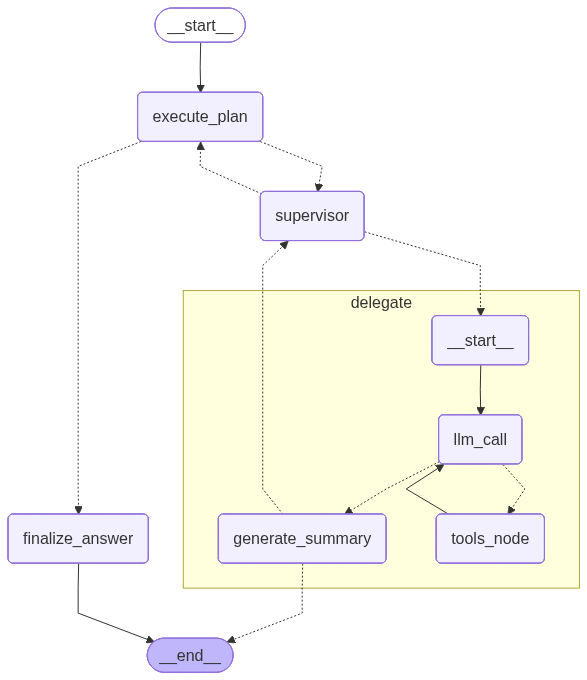

In [50]:
display(Image(supervisor_graph.get_graph(xray=True).draw_mermaid_png()))

In [51]:
result = await supervisor_graph.ainvoke(
    {
        "plan": ["research who is the King of England"],
        "supervisor_messages_buffer": [
            HumanMessage(content="I want to find out who is the King of England")
        ],
        "current_task": "who is the King of England",
    }
)

Execute plan called with state plan: ['research who is the King of England']
Supervisor called
Tool calls detected (1), delegating to subagent.
Delegate called
Supervisor called
Tool calls detected (1), delegating to subagent.
Delegate called
Tool calls detected (1), invoking tools node.
Invoking MCP tool: retrieve_docs with args: {'query': 'current King of England monarch name accession coronation full official title predecessor', 'top_k': 3}
Tool calls detected (1), invoking tools node.
Invoking local tool: tavily_search
Tool calls detected (1), invoking tools node.
Invoking local tool: think_tool
Final response generated, moving to summary.
Generating summary report...
Supervisor called
Tool calls detected (1), delegating to subagent.
Delegate called
Supervisor called
Tool calls detected (1), delegating to subagent.
Delegate called
Tool calls detected (1), invoking tools node.
Invoking MCP tool: retrieve_docs with args: {'query': "King Charles III style title Royal Family official f

In [52]:
rich_console.print(Markdown(result["final_answer"].format_response()))

Final Report: Current King of the United Kingdom — Key Facts and Next Steps                    

Research request: Identify the current King of England (United Kingdom), his name and regnal name, date of         
accession, coronation date (if applicable), full official title, predecessor, and at least three authoritative     
sources.                                                                                                           

 • Current monarch: King Charles III (regnal name: Charles III). []8;id=14381;https://en.wikipedia.org/wiki/Charles_III\Charles III - Wikipedia]8;;\]                         
 • Accession: 8 September 2022 (upon the death of Queen Elizabeth II). []8;id=174420;https://www.britannica.com/biography/Charles-III-king-of-the-United-Kingdom\King Charles III | Biography, Prince, Wife,]8;;\
   ]8;id=427967;https://www.britannica.com/biography/Charles-III-king-of-the-United-Kingdom\Cancer, & Age | Britannica]8;;\]                                                                                     
 • Coronation: 6 May 2023 at Westminster Abbey. []8;id=643126;https://www.theguardian.com/uk-news/2022/oct/11/king-charles-iii-coronation-date-6-may-2023\King Charles III's coronation to take place on 6 May 2023]8;;\]        
 • Predecessor: Queen Elizabeth II. []8;id=161224;https://en.wikipedia.org/wiki/Charles_III\Charles III - Wikipedia]8;;\]                                                      
 • Full official title / style: not present in the supplied excerpts; the formal long-form style is typically      
   published on the official Royal Family website (royal.uk) and should be confirmed there. []8;id=14274;https://www.royal.uk/his-majesty-kings-cypher\His Majesty The King's]8;;\
   ]8;id=335912;https://www.royal.uk/his-majesty-kings-cypher\cypher | The Royal Family]8;;\]                                                                                      
 • Authoritative sources available in the provided content: Wikipedia (Charles III), Britannica (biography), and   
   The Guardian (coronation coverage); additionally consult the official Royal Family site (royal.uk) and the BBC  
   for final confirmation and the exact long-form style. []8;id=654896;https://www.britannica.com/biography/Charles-III-king-of-the-United-Kingdom\King Charles III | Biography, Prince, Wife, Cancer, & Age]8;;\
   ]8;id=270217;https://www.britannica.com/biography/Charles-III-king-of-the-United-Kingdom\| Britannica]8;;\] Conclusion: The monarch's identity, regnal name, accession date, coronation date, and predecessor 
   are confirmed by the provided sources, but the sovereign's full formal style/long form and a BBC confirmation   
   URL were not included in the supplied excerpts and remain to be retrieved for full authoritative verification.  
   Recommendation: retrieve and cite (1) the official Royal Family page that explicitly lists the King's full      
   formal style/title (long-form style), and (2) a BBC article or official announcement confirming his status and  
   the coronation date (6 May 2023); then provide the URLs and include these sources alongside the                 
   already-identified Wikipedia, Britannica, and Guardian references. []8;id=85898;https://www.royal.uk/contact?page=3\Contact | The Royal Family]8;;\]                 

## Scoping

In [53]:
from prompts import ClarificationInput, ClarificationOutput, ClarificationPrompt


def clarify_node(state: RagGraphState) -> Command[Literal["__end__"]]:
    llm_client = ChatOpenAI(
        model_name="gpt-5-mini", temperature=0, max_tokens=4096
    ).with_structured_output(ClarificationOutput)

    messages_list = [
        m.content for m in state["messages"][-5:] if isinstance(m, HumanMessage)
    ]
    result = llm_client.invoke(
        ClarificationPrompt().to_string(ClarificationInput(messages=messages_list))
    )

    if state["clarification_rounds"] > 1:
        return {
            f"messages": [
                AIMessage(
                    content=f"Your request is clear. Will proceed with research on {result.final_statements}."
                )
            ]
        }

    if result.clarification_is_required:
        return Command(
            goto="__end__",
            update={
                "clarification_rounds": state["clarification_rounds"] + 1,
                "messages": [AIMessage(content=result.clarifying_question)],
            },
        )
    return Command(
        goto="__end__",
        update={
            "messages": [
                AIMessage(
                    content=f"Your request is clear. Will proceed with research on {result.final_statements}."
                )
            ],
            "search_topics": result.final_statements,
            "clarification_rounds": state["clarification_rounds"],
        },
    )


def build_scoper_graph():
    checkpointer = InMemorySaver()
    graph_builder = StateGraph(
        state_schema=RagGraphState,
        input_schema=FlowInput,
    )
    graph_builder.add_node("clarify_node", clarify_node)
    graph_builder.add_edge(START, "clarify_node")
    graph_builder.add_edge("clarify_node", END)
    return graph_builder.compile(checkpointer=checkpointer)

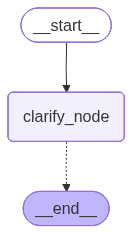

In [54]:
scoper_graph = build_scoper_graph()
display(Image(scoper_graph.get_graph(xray=True).draw_mermaid_png()))

In [55]:
thread = {"configurable": {"thread_id": "1"}}
result = scoper_graph.invoke(
    {"messages": [HumanMessage(content="I want to research new bikes")]}, config=thread
)
result["messages"]

[HumanMessage(content='I want to research new bikes', additional_kwargs={}, response_metadata={}, id='966cc3a5-4328-4db3-8893-e7b27e90e2ad'),
 AIMessage(content='What type of bike are you looking for (road, mountain, hybrid/commuter, gravel, or electric), and what is your approximate budget and intended use?', additional_kwargs={}, response_metadata={}, id='ef164f55-70fc-46c5-8e5e-f04b44393dee')]

In [56]:
result = scoper_graph.invoke(
    {"messages": [HumanMessage(content="I want to find a new gravel bike")]},
    config=thread,
)
result["messages"]

[HumanMessage(content='I want to research new bikes', additional_kwargs={}, response_metadata={}, id='966cc3a5-4328-4db3-8893-e7b27e90e2ad'),
 AIMessage(content='What type of bike are you looking for (road, mountain, hybrid/commuter, gravel, or electric), and what is your approximate budget and intended use?', additional_kwargs={}, response_metadata={}, id='ef164f55-70fc-46c5-8e5e-f04b44393dee'),
 HumanMessage(content='I want to find a new gravel bike', additional_kwargs={}, response_metadata={}, id='dd9e5b0f-3ab2-410b-b127-4603333fb56d'),
 AIMessage(content="Your request is clear. Will proceed with research on ['Research new bikes', 'Find a new gravel bike'].", additional_kwargs={}, response_metadata={}, id='47e0c688-9fe5-438b-9b14-a551604b6f94')]

In [57]:
# result = scoper_graph.invoke({"messages": [HumanMessage(content="And advice would be nice")]}, config=thread)
# result['messages']

In [58]:
result["search_topics"]

['Research new bikes', 'Find a new gravel bike']

## Planning

In [59]:
from prompts import PlannerOutput, PlannerInput, PlanPrompt


def generate_tasks(state: RagGraphState):
    llm_client = ChatOpenAI(
        model_name="gpt-5-mini", temperature=0, max_tokens=4096
    ).with_structured_output(PlannerOutput)

    response = llm_client.invoke(
        PlanPrompt().to_string(
            PlannerInput(
                search_topics=state["search_topics"],
                messages=get_buffer_string(state["messages"]),
            )
        )
    )

    return {
        "plan": response.plan,
        "messages": [AIMessage(content=f"Generated plan: " + ", ".join(response.plan))],
        "max_subagent_calls": 5,
        "subagents_calls": 0,
    }


def build_planner_graph():
    checkpointer = InMemorySaver()
    graph_builder = StateGraph(
        state_schema=RagGraphState,
        input_schema=FlowInput,
    )
    graph_builder.add_node("clarify_node", clarify_node)
    graph_builder.add_node("generate_tasks", generate_tasks)

    graph_builder.add_edge(START, "clarify_node")
    graph_builder.add_edge("clarify_node", "generate_tasks")
    graph_builder.add_edge("generate_tasks", END)
    return graph_builder.compile(checkpointer=checkpointer)

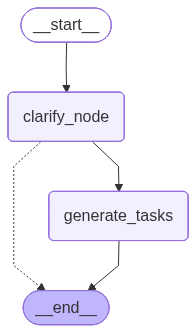

In [60]:
planner_graph = build_planner_graph()
display(Image(planner_graph.get_graph(xray=True).draw_mermaid_png()))

In [61]:
thread = {"configurable": {"thread_id": "2"}}
result = planner_graph.invoke(
    {"messages": [HumanMessage(content="Who is the King of England?")]}, config=thread
)
result["messages"]

[HumanMessage(content='Who is the King of England?', additional_kwargs={}, response_metadata={}, id='ed8a6c5c-b89a-48ae-8d69-daffbd6082b0'),
 AIMessage(content="Your request is clear. Will proceed with research on ['King of England'].", additional_kwargs={}, response_metadata={}, id='613dd48e-0f4c-4b15-ba32-7ee281f2c74e'),
 AIMessage(content="Generated plan: Who is the current monarch and what is their correct regnal name?, What are the accession date and the coronation date (with at least two authoritative citations)?, What is the sovereign's official title and why is using 'King of England' imprecise in modern usage?", additional_kwargs={}, response_metadata={}, id='8bf38763-2f75-4264-b65c-715d70043176')]

In [62]:
result["plan"]

['Who is the current monarch and what is their correct regnal name?',
 'What are the accession date and the coronation date (with at least two authoritative citations)?',
 "What is the sovereign's official title and why is using 'King of England' imprecise in modern usage?"]

## Full graph

In [63]:
def build_full_graph():
    graph_builder = StateGraph(RagGraphState, input_schema=FlowInput)
    checkpointer = InMemorySaver()

    graph_builder.add_node("clarify_node", clarify_node)
    graph_builder.add_node("generate_tasks", generate_tasks)
    graph_builder.add_node("supervisor_graph", supervisor_graph)

    graph_builder.add_edge(START, "clarify_node")
    graph_builder.add_edge("clarify_node", "generate_tasks")
    graph_builder.add_edge("generate_tasks", "supervisor_graph")
    return graph_builder.compile(checkpointer=checkpointer)

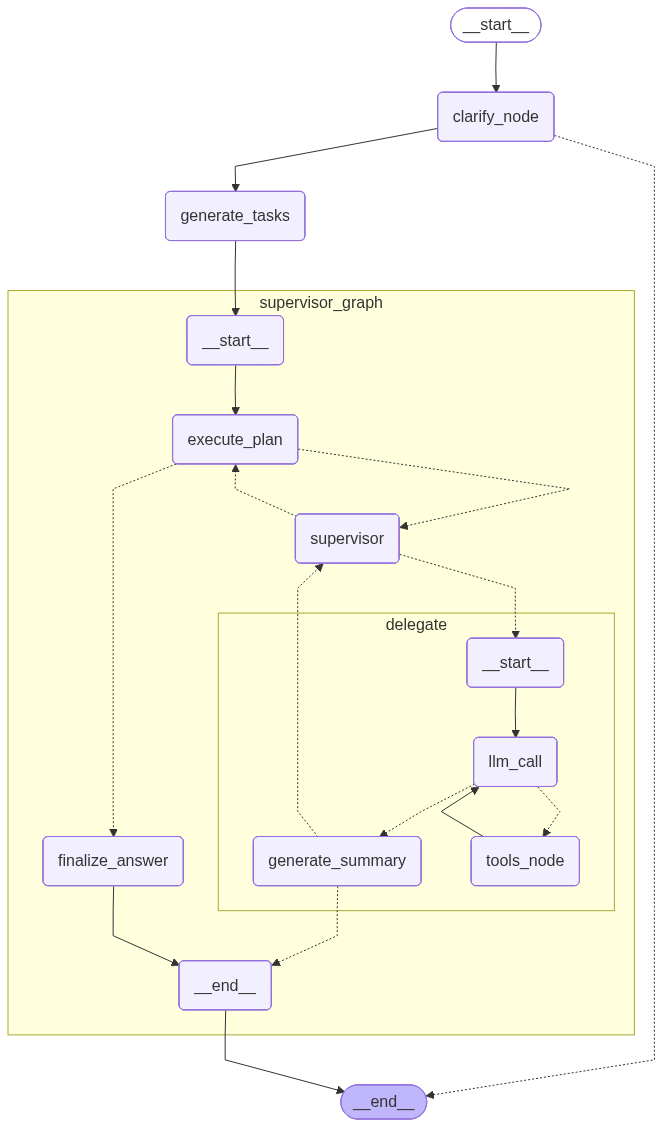

In [64]:
agentic_rag = build_full_graph()
display(Image(agentic_rag.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
thread = {"configurable": {"thread_id": "102"},
          "recursion_limit": 50, 
        #   "callbacks": [langfuse_handler]
          }
result = await agentic_rag.ainvoke(
    {
        "messages": [
            HumanMessage(content="I am looking for a new bike")
        ]
    },
    config=thread
)

Execute plan called with state plan: ['Which bike type (road, gravel, mountain, hybrid/commuter, or e-bike) best matches the user’s primary use, typical terrain, and priority features (comfort, speed, cargo, range)?', 'Given the chosen bike type and the user’s budget, which 4–6 specific models or build levels are the best options (expected component level, pros/cons, and notes on typical price ranges)?', 'What exact size and fit measurements (reach, stack, saddle height/inseam) and what 8–10 point test-ride / pre-purchase checklist should the buyer use to confirm the bike fits and performs before purchase?']
Supervisor called
Tool calls detected (1), delegating to subagent.
Delegate called
Supervisor called
Tool calls detected (1), delegating to subagent.
Delegate called
Tool calls detected (1), invoking tools node.
Invoking MCP tool: retrieve_docs with args: {'query': 'bike types road gravel mountain hybrid commuter e-bike tire widths gearing ranges battery watt-hours typical specs', 

In [ ]:
display(Markdown(result["final_answer"]))

# References

1. [deep_research_from_scratch](https://github.com/langchain-ai/deep_research_from_scratch)
2. [workflows and agents](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/workflows.md)
3. [anthropic-cookbook](https://github.com/anthropics/anthropic-cookbook/tree/main/patterns/agents)
4. [Build an MCP Server - Model Context Protocol](https://modelcontextprotocol.io/quickstart/server)
5. [Building Effective AI Agents \ Anthropic](https://www.anthropic.com/engineering/building-effective-agents)
6. [How we built our multi-agent research system \ Anthropic](https://www.anthropic.com/engineering/multi-agent-research-system)
7. [Tavily](https://docs.tavily.com/documentation/quickstart)
8. [Tools in Langchain](https://python.langchain.com/docs/concepts/tools/)
9. [openai agents patterns](https://github.com/openai/openai-agents-python/tree/main/examples/agent_patterns)
10. [openai agents guide](https://platform.openai.com/docs/guides/agents)  
11. [Schema-Guided Reasoning (SGR)](https://abdullin.com/schema-guided-reasoning/)  
12. [Trace and Evaluate LangGraph Agents - Langfuse](https://langfuse.com/guides/cookbook/example_langgraph_agents)  